In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import fitsio
import desimodel.io
import desitarget.mtl
from desitarget.targetmask import desi_mask, obsconditions
from collections import Counter
%matplotlib inline

In [32]:
def get_ids(tgdata):
    tgprops = dict()
    ii = (tgdata['DEVICE_TYPE']=='POS') & (tgdata['TARGETID']>0)
    assigned_ids = tgdata[ii]
    return assigned_ids['TARGETID']

def count_numobs_done(data_path, mtl_file):
    # list the fiberassignment files available
    tile_files = glob.glob(os.path.join(data_path, "fiberassign_*"))
    print('number of available tile files', len(tile_files))
    
    # getting all the targetids of the assigned fibers
    print('reading the individual fiberassign files')
    prop_assign = dict()
    for i_tile, tile_file in enumerate(tile_files):
        if i_tile%200 ==0:
            print(i_tile)
        assignments = Table.read(tile_file, hdu=1)
        prop_assign[i_tile] = get_ids(assignments)
    
    # consolidate a single list of assigned targetids
    print('consolidating a single list of targets')
    assigned = list()
    for k in prop_assign.keys():
        assigned.extend(list(prop_assign[k]))
        
    # count how many times each target was assigned
    print('counting how many times each target was assigned')
    counts_assigned = Counter(assigned)
    ids_assigned = list(counts_assigned.keys())
    
    print('loading mtl file')
    # load the original mtl file used as an input to fiberassign
    input_mtl_data = Table.read(mtl_file)
    
    #adding a new column to the mtl file
    print('adding new column')
    input_mtl_data['NUMOBS_DONE'] = np.zeros(len(input_mtl_data), dtype=int)
    
    #finding what targets in the mtl file overlap with the assignment results
    print('finding ID overlap')
    overlap_ids = np.isin(input_mtl_data['TARGETID'], ids_assigned)
    
    #update the new column
    print('updating NUMOBS_DONE')
    for i, overlap in enumerate(overlap_ids):
        if overlap:
            input_mtl_data['NUMOBS_DONE'][i] = counts_assigned[input_mtl_data['TARGETID'][i]]
            
    outputfile = mtl_file.replace('mtl','fiberassigned_mtl')
    print('Writing the new results to {}'.format(outputfile))
    input_mtl_data.write(outputfile)
    print('done')

In [28]:
count_numobs_done("dark_south_fiberassign/", "dr8_mtl_dark_gray_southern_cap.fits")

number of available tile files 3085
reading the individual fiberassign files
0
consolidating a single list of targets
counting how many times each target was assigned
loading mtl file
adding new column
finding ID overlap
updating NUMOBS_DONE
Writing the new results to dr8_fiberassigned_mtl_dark_gray_southern_cap.fits
done


In [29]:
fiberassigned_mtl = Table.read("dr8_fiberassigned_mtl_dark_gray_southern_cap.fits")

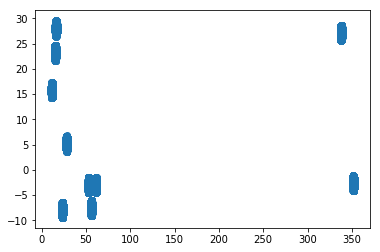

In [31]:
ii = fiberassigned_mtl['NUMOBS_DONE']==1
plt.scatter(fiberassigned_mtl['RA'][ii], fiberassigned_mtl['DEC'][ii])

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000


In [100]:
print(len(ids_assigned))
print(len(input_mtl_data))

12012272
26788090


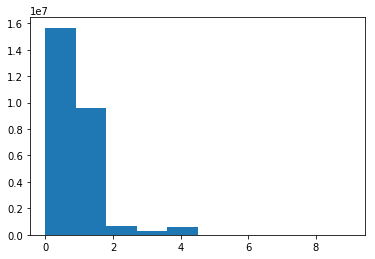

In [104]:
_ = plt.hist(input_mtl_data['N_OBS_DONE'])

In [ ]:
ii = input_mtl_data['N_OBS_DONE']==0
plt.scatter(input_mtl_data['RA'][ii], input_mtl_data['DEC'][ii], s=0.001, alpha=0.2)

In [1]:
print(len(overlap_ids))

NameError: name 'overlap_ids' is not defined